In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
import re
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Bidirectional
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load data
df = pd.read_csv('./data/product_df.csv')
df = df[['Star Rating', 'Comment']]

In [3]:
def label_sentiment(rating):
    if rating in [1, 2]:
        return '0'
    elif rating == 3:
        return '1'
    elif rating in [4, 5]:
        return '2'
    else:
        return '3'  # Nếu có xếp hạng nằm ngoài khoảng 1-5

# Gắn nhãn cảm xúc cho mỗi đánh giá
df['Sentiment'] = df['Star Rating'].apply(label_sentiment)

# Hiển thị 5 hàng đầu tiên của dataframe với cột sentiment mới
print(df.head())

   Star Rating                                            Comment Sentiment
0            4                      Điện thoại này dùng rất thích         2
1            4                               sử dụng thấy cũng ok         2
2            2                      Bảo hành ít quá, chỉ 12 tháng         0
3            5                             Sản phẩm mượt, chạy êm         2
4            3  Cho mình hỏi muốn khởi động lại máy hay tắt ng...         1


In [4]:
# Kiểm tra và loại bỏ giá trị khuyết thiếu
print(df.isnull().sum())
df = df.dropna(subset=['Comment'])
# Kiểm tra và loại bỏ dữ liệu trùng lặp
duplicate_comments = df[df.duplicated(['Comment'])]
print("Các dòng dữ liệu trùng lặp trong cột 'Comment':")
print(duplicate_comments)
df = df.drop_duplicates(['Comment'])
print("Shape after dropping duplicates:", df.shape)

Star Rating    0
Comment        0
Sentiment      0
dtype: int64
Các dòng dữ liệu trùng lặp trong cột 'Comment':
      Star Rating                                   Comment Sentiment
48              4                                   Rất tốt         2
76              5                                    Rất ok         2
107             2                             pin tụt nhanh         0
135             5                              sản phẩm tốt         2
173             2                             hao pin nhanh         0
177             5                              sản phẩm tốt         2
181             5                                    Rất ok         2
183             5                              sản phẩm tốt         2
192             5                               sản phẩm ok         2
205             5                               máy dùng ok         2
225             4                                       Tốt         2
227             5                               

In [5]:
# Chuẩn hóa và làm sạch văn bản
def remove_special_characters(text):
    # Loại bỏ các ký tự đặc biệt, giữ lại chữ cái, số, và các dấu câu
    return re.sub(r'[^a-zA-ZÀ-ỹà-ỹ0-9\s]', '', text)

def to_lowercase(text):
    # Chuyển đổi văn bản về chữ thường
    return text.lower()

def normalize_text(text):
    text = remove_special_characters(text)
    text = to_lowercase(text)
    return text

df['Comment'] = df['Comment'].apply(normalize_text)
print(df.head())

   Star Rating                                            Comment Sentiment
0            4                      điện thoại này dùng rất thích         2
1            4                               sử dụng thấy cũng ok         2
2            2                       bảo hành ít quá chỉ 12 tháng         0
3            5                              sản phẩm mượt chạy êm         2
4            3  cho mình hỏi muốn khởi động lại máy hay tắt ng...         1


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['Comment'] = df['Comment'].apply(normalize_text)

# Tokenization bằng Underthesea
df['Tokenized_Comment'] = df['Comment'].apply(lambda x: word_tokenize(x))

# Chuyển đổi văn bản thành ma trận TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Tokenized_Comment'].tolist())

# In ra số lượng từ vựng và ma trận TF-IDF
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

Vocabulary size: 1771
TF-IDF Matrix shape: (1498, 1771)


c:\Users\vuhamy\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Độ dài tối đa của câu sau khi được padding (tùy vào nhu cầu của bạn)
max_length = 40

# Số chiều của không gian nhúng (embedding dimension)
embedding_dim = 50

# Số lượng từ trong từ điển (ví dụ: kích thước của vocab_list)
vocab_size = len(tfidf_vectorizer.vocabulary_)

# Xây dựng mô hình CNN
model = Sequential()

# Lớp Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Lớp Convolutional
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Lớp Global Max Pooling
model.add(GlobalMaxPooling1D())

# Lớp Dense (fully connected)
model.add(Dense(3, activation='softmax'))  # 3 là số lượng lớp đầu ra (cảm xúc: neutral, positive, negative)

# Compile mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = pad_sequences(tfidf_matrix.toarray(), maxlen=max_length)
y = pd.get_dummies(df['Sentiment']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tăng số lượng epochs và điều chỉnh kích thước batch
model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test))

# Hiển thị cấu trúc của mô hình
model.summary()


c:\Users\vuhamy\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5316 - loss: 1.0233 - val_accuracy: 0.5967 - val_loss: 0.9625
Epoch 2/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5298 - loss: 1.0086 - val_accuracy: 0.5967 - val_loss: 0.9419
Epoch 3/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5563 - loss: 0.9879 - val_accuracy: 0.5967 - val_loss: 0.9701
Epoch 4/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5352 - loss: 0.9915 - val_accuracy: 0.5967 - val_loss: 0.9538
Epoch 5/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5221 - loss: 1.0104 - val_accuracy: 0.5967 - val_loss: 0.9375
Epoch 6/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5384 - loss: 0.9972 - val_accuracy: 0.5967 - val_loss: 0.9414
Epoch 7/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5297 - loss: 1.0028 - val_accuracy: 0.5967 - val_loss: 0.9381
Epoch 8/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5311 - loss: 1.0036 - val_accuracy: 0.5967 - v

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 40, 50)         │        88,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 36, 128)        │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,197 (1.39 MB)

 Trainable params: 121,065 (472.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,132 (945.83 KB)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred_labels are already defined from your previous steps

# Convert one-hot encoded y_test back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_test_labels, y_pred_labels))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.00      0.00      0.00        43
           2       0.60      1.00      0.75       179

    accuracy                           0.60       300
   macro avg       0.20      0.33      0.25       300
weighted avg       0.36      0.60      0.45       300



c:\Users\vuhamy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vuhamy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vuhamy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5383 - loss: 0.9870 - val_accuracy: 0.5967 - val_loss: 0.9416
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5457 - loss: 0.9842 - val_accuracy: 0.5967 - val_loss: 0.9441
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5569 - loss: 0.9743 - val_accuracy: 0.5967 - val_loss: 0.9416
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5421 - loss: 0.9856 - val_accuracy: 0.5967 - val_loss: 0.9428
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5621 - loss: 0.9749 - val_accuracy: 0.5967 - val_loss: 0.9428
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5528 - loss: 0.9798 - val_accuracy: 0.5967 - val_loss: 0.9415
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5473 - loss: 0.9897 - val_accuracy: 0.5967 - val_loss: 0.9427
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5357 - loss: 0.9988 - val_accuracy: 0.5967 - v

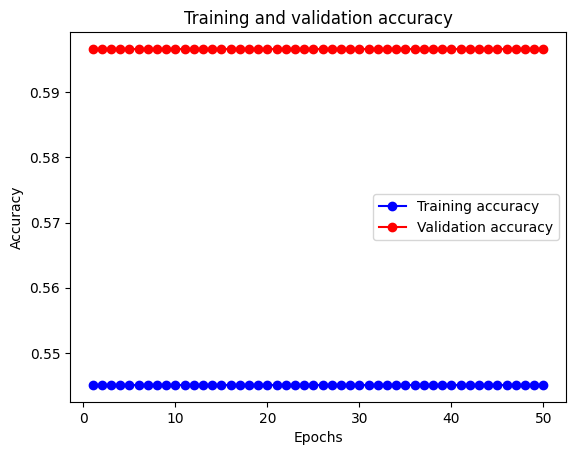

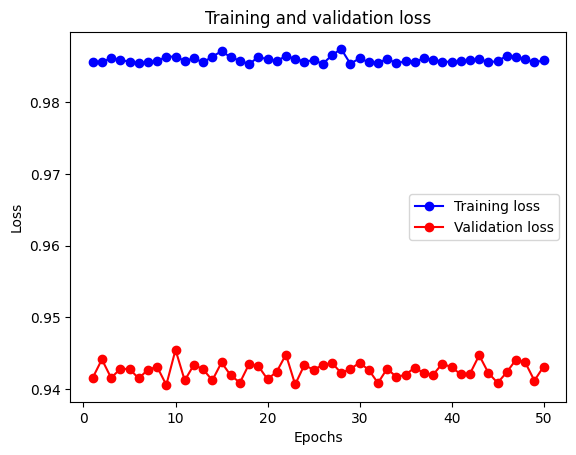

In [16]:
import matplotlib.pyplot as plt

# Huấn luyện mô hình và lưu lại lịch sử huấn luyện
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Lấy các thông số accuracy và loss từ lịch sử huấn luyện
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ learning curves
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
